# Advanced Statistical Inference -- Gaussian Process for Regression

Today, we will play with Gaussian processes. By the end of this lab, you will be able to 
 
- To sample from a Gaussian process prior distribution.
- To implement Gaussian process inference for regression.
- To use the above to observe samples from a Gaussian process posterior distribution.
- To evaluate how different hyperparameter settings impact model quality.
- To investigate different kernel functions and parameter optimisation strategies.

Gaussian processes (henceforth GPs) achieve greater flexibility over parametric models by imposing a preference bias as opposed to restrictive constraints. Although the parameterisation of GPs allows one to access a certain (infinite) set of functions, preference can be expressed using a prior over functions. This allows greater freedom in representing data dependencies, thus enabling the construction of better-suited models. In this lab, we shall cover the basic concepts of GP regression. For the sake of clarity, we shall focus on univariate data, which allows for better visualisation of the GP model. Nonetheless, the code implemented within this lab can be very easily extended to handle
multi-dimensional inputs.

### Disclaimer
For this notebook, we will use a slightly different library (jax). For what we are concerned, Jax is just numpy with automatic differentiation: it implements all numpy functions and also their derivatives. For what we need, the change in the code is as small as replacing `np.something` with `jnp.something`. That's it! Nothing more!
Later in the notebook, we will see how this small change in the code allows to compute gradients in an embarrassingly simple way. 


In [107]:
import functools
import warnings

import jax
import jax.numpy as jnp
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rc

warnings.filterwarnings("ignore")

#colab = "google.colab" in str(get_ipython())
#preamble = r"""\renewcommand{\familydefault}{\sfdefault} \usepackage{FiraSans}
#            \usepackage{sansmath} \sansmath  \usepackage{amsmath}"""
#rc("font", **{"family": "sans-serif", "sans-serif": "DejaVu Sans"})
#rc("text", **{"usetex": not colab, "latex.preamble": preamble})
#rc("figure", **{"dpi": 200})
#rc(
#    "axes",
#    **{"spines.right": False, "spines.top": False, "xmargin": 0.0, "ymargin": 0.05}
#)


def plot_data(X, y, ax):
    config = dict(edgecolor="black", linewidth=1, facecolor="tab:blue")
    ax.scatter(X, y, label="Data points", zorder=10, **config)


For this notebook, we shall consider a one-dimensional regression problem.

**Exercise:**
Run the next cell to prepare and plot the data

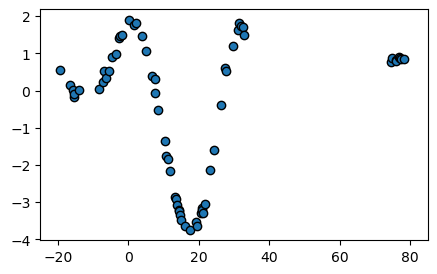

In [108]:
np.random.seed(3424121)


def make_dataset(a=-20, b=80, N=64, M=200, gap_ratio=0.4, ampl=1.6, leng=8, sn2=0.01):
    def make_random_gap(X, gap_ratio=0.2):
        a, b = X.min(), X.max()
        gap_a = a + np.random.rand() * (b - a) * (1 - gap_ratio)
        gap_b = gap_a + (b - a) * gap_ratio
        idx = np.logical_and(gap_a < X, X < gap_b)
        X[idx] = a + np.random.rand(idx.sum()) * (gap_a - a)
        return X

    def sample_random_function(X, ampl=1, leng=1, sn2=0.1):
        n, x = X.shape[0], X / leng
        sum_xx = np.sum(x * x, 1).reshape(-1, 1).repeat(n, 1)
        D = sum_xx + sum_xx.transpose() - 2 * np.matmul(x, x.transpose())
        C = ampl**2 * np.exp(-0.5 * D) + np.eye(n) * sn2
        return np.random.multivariate_normal(np.zeros(n), C)

    X = np.random.rand(N, 1) * (b - a) + a
    X = make_random_gap(X, gap_ratio=0.4)
    ind = np.argsort(X[..., 0])
    y = sample_random_function(X, ampl=ampl, leng=leng, sn2=sn2)
    Xt = np.linspace(a - 5, b + 5, M).reshape(-1, 1)
    return X[ind], y[ind], Xt


X, y, Xt = make_dataset()
fig, ax = plt.subplots(figsize=[5, 3])
plot_data(X, y, ax)
ax.set_xlim(Xt.min(), Xt.max())
plt.show()

# 1. Sampling from the GP Prior


Recall that since GPs are non-parametric; we define a prior distribution over functions (models),
specified as a multivariate Gaussian distribution $p(\boldsymbol f) = \mathcal{N} (\boldsymbol\mu, \boldsymbol\Sigma)$.

Without loss of generality, we shall assume a zero-mean GP prior, i.e. $\boldsymbol\mu = \boldsymbol 0$. The covariance
matrix of the distribution, $\boldsymbol\Sigma$, may then be computed by evaluating the covariance between the
input points. For this tutorial, we shall consider the widely used squared-exponential (RBF)
covariance (also referred to as the kernel function), which is defined between two points as: 

$$\kappa(\boldsymbol x, \boldsymbol x') = \sigma_f^2 \exp \Big( -\dfrac {\|\boldsymbol x-\boldsymbol x'\|^2}{2l^2} \Big). $$

This kernel is parameterised by a lengthscale parameter $l$, and variance $\sigma_{f}^2$ . Given that the true
function may be assumed to be corrupted with noise, we can also add a noise parameter, $\sigma_\mathrm{n}^2$ , to
the diagonal entries of the resulting kernel matrix, $\boldsymbol K_y$, such that

$$\boldsymbol K_y = \boldsymbol K + \sigma_{n}^2\boldsymbol I.$$


**Exercise:**
Complete the `rbf_kernel()` function for computing the RBF kernel $\boldsymbol K$ between two sets of input points. For a bit of flexibility
the kernel parameters are saved in a dictionary and passed as first argument to the function.
Hint: The `cdist` function can be used for evaluating the pairwise squared Euclidean distance between two sets of points.

In [109]:
def cdist(A, B):
    """
    Compute all pairwise distances between vectors in A and B.
    """
    M = A.shape[0]
    N = B.shape[0]
    A_dots = (A * A).sum(axis=1).reshape((M, 1)) * jnp.ones(shape=(1, N))
    B_dots = (B * B).sum(axis=1) * jnp.ones(shape=(M, 1))
    D_squared = A_dots + B_dots - 2 * A.dot(B.T)
    return D_squared


def rbf_kernel(params, X1, X2):
    lengthscale = params["lengthscale"]
    variance = params["variance"]
    D = cdist(X1, X2)
     # @@ COMPLETE @@ #
    return variance * jnp.exp(-0.5 * D * lengthscale**-2)

**Exercise:** Compute the kernel matrix $\kappa(\boldsymbol{X}, \boldsymbol{X})$. Plot it using `plt.imshow()`. Start with $\sigma^2_f$ and $l$ both equal to one. Then try to change this two parameter. What do you see? Comment the figure.

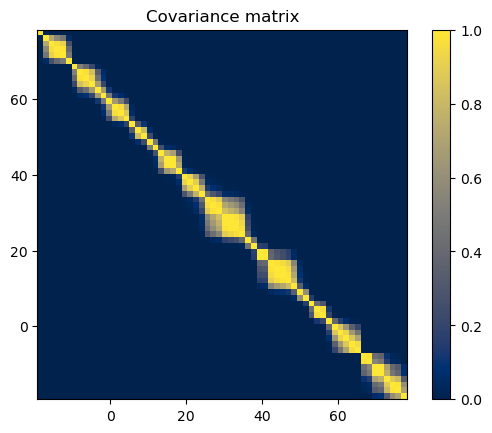

In [110]:
params = {"lengthscale": 1.0, "variance": 1}

K =  rbf_kernel(params, X, X) # @@ COMPLETE @@ #

fig, ax = plt.subplots()
bar = ax.imshow(K, extent=[X.min(), X.max(), X.min(), X.max()], cmap="cividis")
fig.colorbar(bar)
ax.set_title(r"Covariance matrix")
plt.show()

### Exercise:

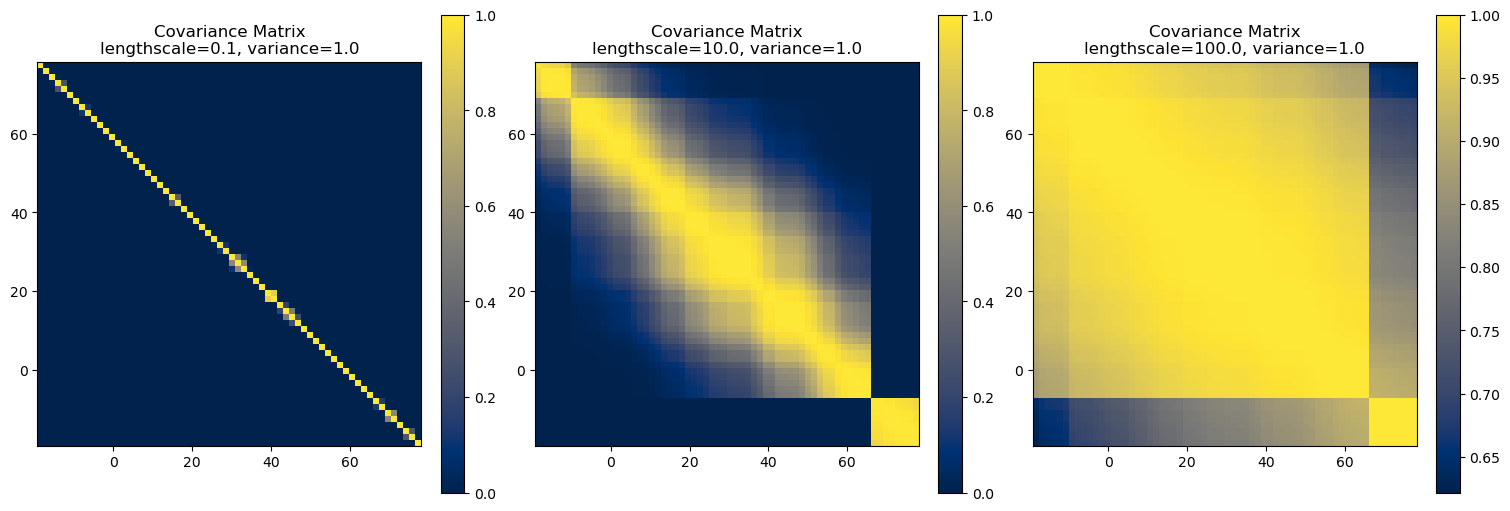

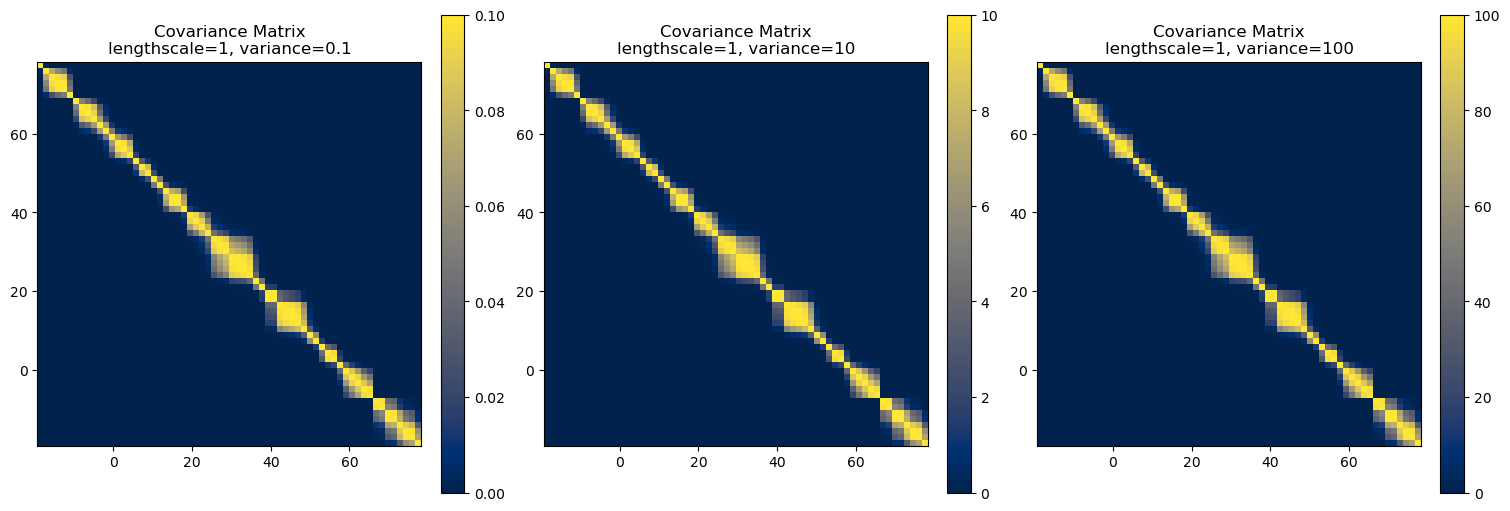

In [111]:
params_list = [
    {"lengthscale": 0.1, "variance": 1.0},
    {"lengthscale": 10.0, "variance": 1.0},
    {"lengthscale": 100.0, "variance": 1.0}
]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

for i, params in enumerate(params_list):
    K = rbf_kernel(params, X, X)
    bar = axs[i].imshow(K, extent=[X.min(), X.max(), X.min(), X.max()], cmap="cividis")
    fig.colorbar(bar)
    axs[i].set_title(f"Covariance Matrix\nlengthscale={params['lengthscale']}, variance={params['variance']}")

plt.show()

params_list = [
    {"lengthscale": 1, "variance": 0.1},
    {"lengthscale": 1, "variance": 10},
    {"lengthscale": 1, "variance": 100}
]
fig, axs = plt.subplots(1, 3, figsize=(15, 5), constrained_layout=True)

for i, params in enumerate(params_list):
    K = rbf_kernel(params, X, X)
    bar = axs[i].imshow(K, extent=[X.min(), X.max(), X.min(), X.max()], cmap="cividis")
    fig.colorbar(bar)
    axs[i].set_title(f"Covariance Matrix\nlengthscale={params['lengthscale']}, variance={params['variance']}")

plt.show()


**Comments**:
- Increasing lengthscale $l$ will make $k(x, x')$ close to $\sigma_f^2$ for all $x$ and $x'$, thus we can see that in the kernel matrix, all the random variables have high covariance even if they are far apart. 
- Decreasing lengthscale $l$ will make $k(x, x')$ close to $\sigma_f^2$ only for $x$ and $x'$ close to each other, thus we can see that in the kernel matrix, the random variables have high covariance only if they are close to each other. (extreme case: $l\rightarrow 0$, $k(x,x')\rightarrow \delta(x-x')$)
- Modifying $\sigma_f$ will change the variance of the random variables. As we can see from the different values in the colorbars of the plots on the second row.

Now you are ready to sample from the GP prior. Remember if $f$ follows a GP, ie $f \sim \mathcal{GP}(\mu(\cdot), \kappa(\cdot,\cdot))$, then the function $f$ computed at points $X$ will have this prior $p(\boldsymbol{f}) = \mathcal{N}(\boldsymbol\mu, \boldsymbol{\Sigma})$, where $\boldsymbol\mu = \mu(\boldsymbol X)$ and $\boldsymbol\Sigma = \kappa(\boldsymbol X, \boldsymbol X)$. 

Below you will find a couple of functions to plot a GP and some samples.

In [112]:
def plot_gp(x, mean, cov, palette="Greens", **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    cmap = plt.get_cmap(palette)
    ci = [1, 2, 3]
    colors = (ci - np.min(ci)) / (np.max(ci) - np.min(ci) + 3) + 0.1
    x = x.flatten()
    ax.plot(x, mean, color=cmap(0.9), lw=4)
    for i, c in enumerate(ci[::-1]):
        up = mean + c * np.sqrt(np.diag(cov))
        lo = mean - c * np.sqrt(np.diag(cov))
        color = cmap(colors[i])
        ax.fill_between(x, up, lo, color=color, alpha=0.95, **kwargs)
    return ax


def plot_samples(x, samples, palette="Greens", **kwargs):
    ax = kwargs.pop("ax", plt.gca())
    N = kwargs.pop("N", 20)
    cmap = plt.get_cmap(palette)
    idx = np.random.randint(0, samples.shape[0], N)
    ax.plot(x, samples[idx].T, color=cmap(0.5), lw=1, alpha=0.75, **kwargs)
    return ax

**Exercise:**
Assuming a zero-mean prior, and using the RBF kernel constructed before, complete the following function to sample from the prior (use `np.random.multivariate_normal()` function).
For the time being, you can initialise the kernel parameters as follows:

- lengthscale = 15.0
- variance = 2.0

Note: make sure these parameters are floats (not integers).

In [113]:
def sample_f_prior(params, kernel_fn, Xt, N=20):
    mean = np.zeros(len(Xt)) # @@ COMPLETE @@ #
    cov = kernel_fn(params, Xt, Xt) # @@ COMPLETE @@ #
    samples = np.random.multivariate_normal(mean, cov, N) # @@ COMPLETE @@ # 
    return samples, mean, cov


params = {"lengthscale": 15.0, "variance": 2.0}

samples, mean, cov = sample_f_prior(params, rbf_kernel, Xt)

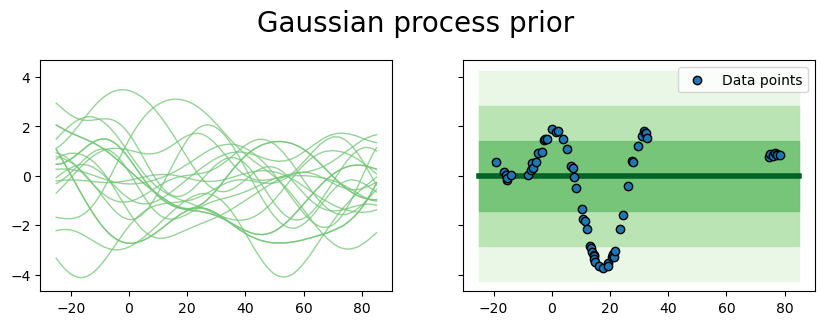

In [114]:
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(r"Gaussian process prior", y=1.05, fontsize=20)
plt.show()

**Exercise:** Try to change the kernel hyperparameters and plot few samples from their corresponding GP prior. What do you observe?

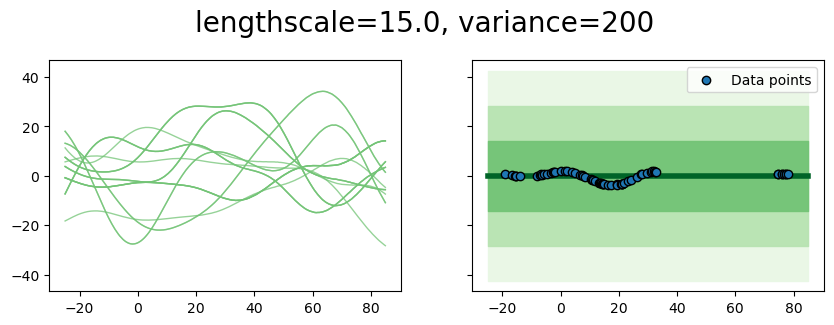

In [115]:
params_2 = {"lengthscale": 15.0, "variance": 200}

samples, mean, cov = sample_f_prior(params_2, rbf_kernel, Xt)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']}", y=1.05, fontsize=20)
plt.show()

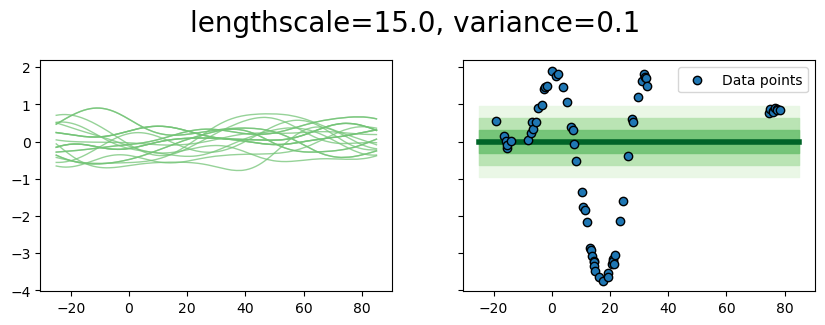

In [116]:
params_2 = {"lengthscale": 15.0, "variance": 0.1}

samples, mean, cov = sample_f_prior(params_2, rbf_kernel, Xt)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']}", y=1.05, fontsize=20)
plt.show()

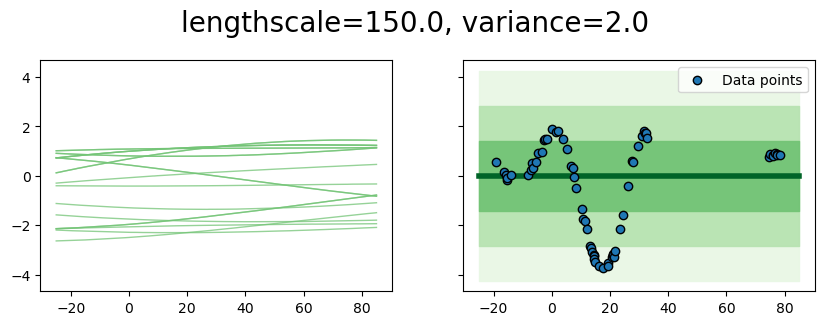

In [117]:
params_2 = {"lengthscale": 150.0, "variance": 2.0}

samples, mean, cov = sample_f_prior(params_2, rbf_kernel, Xt)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']}", y=1.05, fontsize=20)
plt.show()

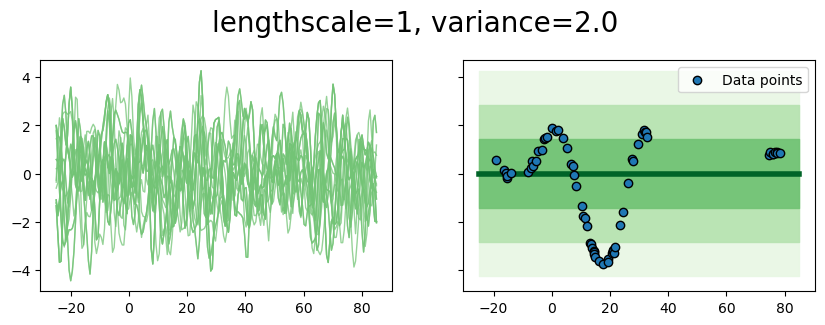

In [118]:
params_2 = {"lengthscale": 1, "variance": 2.0}

samples, mean, cov = sample_f_prior(params_2, rbf_kernel, Xt)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']}", y=1.05, fontsize=20)
plt.show()

- Modifying lengthscale $l$ will change the smoothness of the samples. As we increase we lose the concept of similarity, and the samples tend to be straight lines. As we decrease, the samples tend to be less smooth, since only points close to each other have high covariance.

- Modifying $\sigma_f$ will change the variance of the samples. As we increase the variance, the samples will have a higher amplitude. As we decrease the variance, the samples will have a lower amplitude. (As we can see on the y-axis of the plot that ranges from -40 to 40 when we increased the variance, and -1 to 1 when we decreased the variance).


# 2. Inference with GP

Recall that the prior represents our prior beliefs before observing the function values of any data points. Suppose we can now observe 3 points at random from the input data; we would expect that with this additional knowledge, the functions drawn from the updated GP distribution would be constrained to pass through these points (or at least close if corrupted with noise). The combination of the prior and the likelihood of the observed data leads to the posterior distribution over functions.

During the lecture, you have derived the posterior distribution of the GP given data $\{\mathbf{X},\mathbf{y}\}$ (check the lecture note if you don't remeber).

**Note**: As we have encountered in previous labs, matrix inversions can be both numerically troublesome and slow to compute. 
In this lab, we shall avoid computing matrix inversions directly by instead considering Cholesky decompositions for solving linear systems. 
You are encouraged to read more about Cholesky decompositions for GPs by consulting Appendix A.4 of [Gaussian Processes for Machine Learning (Rasmussen and Williams, 2005)](http://www.gaussianprocess.org/gpml/) - available online!
The complete pseudo-code for the posterior inference procedure is provided in Algorithm 2.1 from Chapter 2 of this same book.
Unfortunately, that Algorithm explains how to compute the posterior one test point at a time. You could loop through all test points but this is not very efficient. Instead you can compute the posterior for all points in one shot, by remembering that


$$p(\boldsymbol{f_\star}\,|\,\boldsymbol{y}) = \mathcal{N}(\boldsymbol{f}_{\text{mean}}, \boldsymbol{f}_{\text{cov}}) $$

$$\boldsymbol{f}_{\text{mean}} =  \kappa(\boldsymbol{X}_\star, \boldsymbol{X})\left[\kappa(\boldsymbol{X}, \boldsymbol{X}) + \sigma_n^2 I\right]^{-1}\boldsymbol{y}$$

$$\boldsymbol{f}_{\text{cov}} =  \kappa(\boldsymbol{X}_\star, \mathbf{X}_\star) - \kappa(\boldsymbol{X}_\star, \boldsymbol{X})\left[\kappa(\boldsymbol{X}, \boldsymbol{X}) + \sigma_{n}^2 I\right]^{-1}\kappa(\boldsymbol{X}_\star, \boldsymbol{X})^\top$$


**Exercise:** 
Complete the following function to compute the GP posterior GP.

In [119]:
def predict_f_posterior(params, kernel_fn, X, y, Xt, sn2=0.01):
     Kx = kernel_fn(params, X, Xt) # @@ COMPLETE @@ #
     K = kernel_fn(params, X, X) + sn2 * jnp.eye(len(X)) # @@ COMPLETE @@ #
     L = jnp.linalg.cholesky(K)
     A = jnp.linalg.solve(L, Kx)
     V = jnp.linalg.solve(L, y)
     # @@ COMPLETE @@ #
     fmean =  A.T @ V# @@ COMPLETE @@ #
     fcov =  kernel_fn(params, Xt, Xt) - A.T @ A # @@ COMPLETE @@ #
     return fmean, fcov

**Exercise:** Assign 3 points at random from $\boldsymbol{X}$ (and their corresponding function values) to `Xtr` and `ytr`
respectively. For now we shall assume that all other $\boldsymbol{X}$ values are unobserved. 

In [120]:
np.random.seed(14)
idx = np.random.permutation(len(X))[:5]

Xtr =  X[idx]# @@ COMPLETE @@ #
ytr =  y[idx]# @@ COMPLETE @@ #

**Exercise:** 
Run the previously completed function to compute the GP posterior.

In [121]:
# @@ COMPLETE @@ #
f_mean, f_cov = predict_f_posterior(params, rbf_kernel, Xtr, ytr, Xt)

**Exercise:**
Sample few times from the posterior and, using the helper functions defined above, plot the samples and their distribution. 

In [122]:
np.random.seed(0)
samples = np.random.multivariate_normal(f_mean, f_cov, 50) #NB: la funzione la vedi come una multivariate in cui il vettore sono tutti i possibili valori
# @@ COMPLETE @@ #

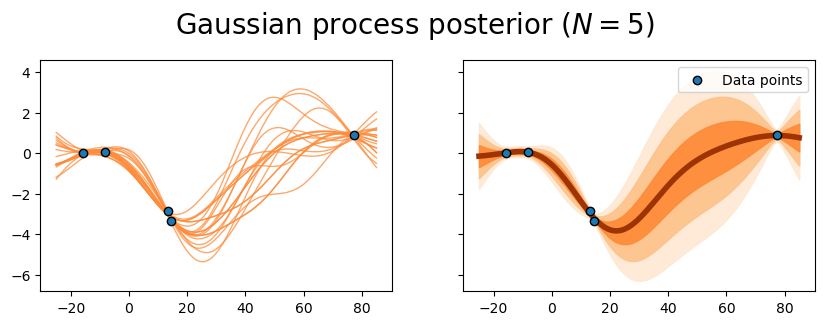

In [123]:

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(Xtr, ytr, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(Xtr, ytr, ax1)
ax1.legend()
fig.suptitle(f"Gaussian process posterior ($N={len(Xtr)}$)", y=1.05, fontsize=20)

plt.show()

**Exercise:**
Try to add more samples. Also plot the posterior with all the data available. What do you see?

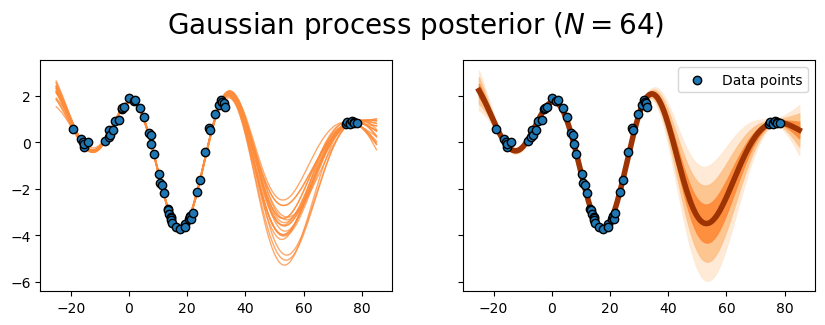

In [124]:
f_mean, f_cov = predict_f_posterior(params, rbf_kernel, X, y, Xt)
np.random.seed(0)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(X, y, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"Gaussian process posterior ($N={len(X)}$)", y=1.05, fontsize=20)

plt.show()

**Comments:** We can see that, as we increase the data points, the posterior becomes more confident around the observed points. 

**Exercise:**
Try to change the kernel parameters (lengthscale and variance). Plot the posterior for 3/4 combinations. 

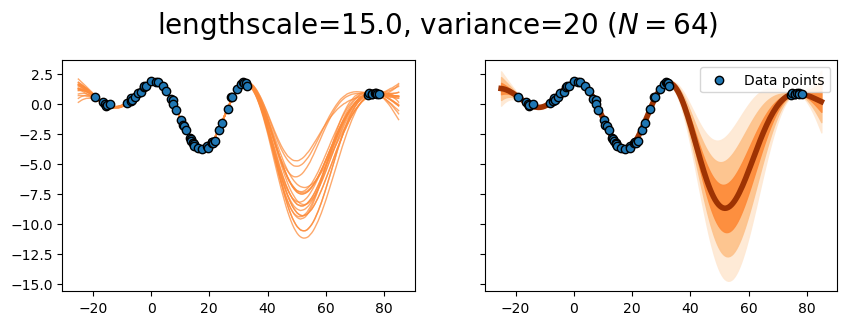

In [125]:
# @@ COMPLETE @@ #
params_2 = {"lengthscale": 15.0, "variance": 20}
f_mean, f_cov = predict_f_posterior(params_2, rbf_kernel, X, y, Xt)
np.random.seed(0)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(X, y, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']} ($N={len(X)}$)", y=1.05, fontsize=20)


plt.show()

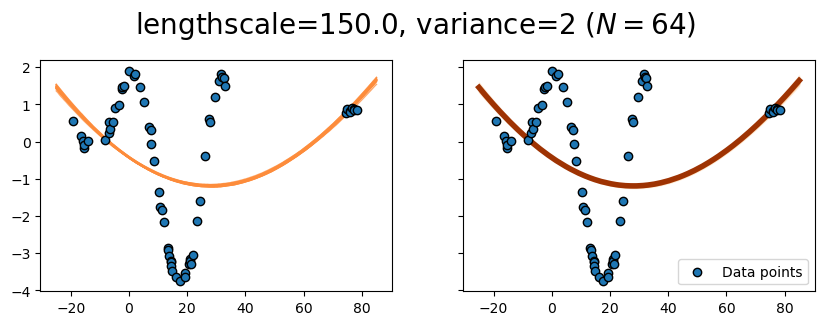

In [126]:
params_2 = {"lengthscale": 150.0, "variance": 2}
f_mean, f_cov = predict_f_posterior(params_2, rbf_kernel, X, y, Xt)
np.random.seed(0)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(X, y, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']} ($N={len(X)}$)", y=1.05, fontsize=20)


plt.show()

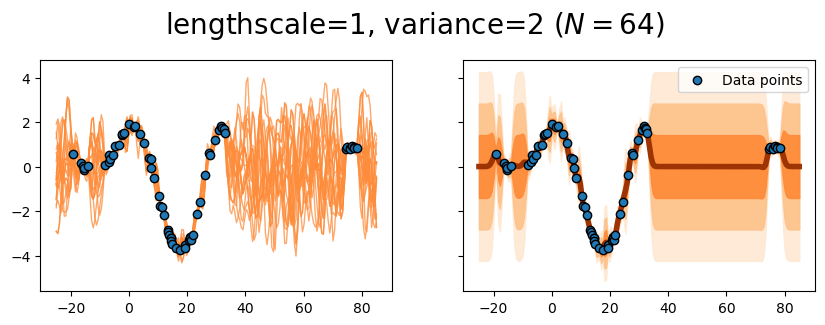

In [127]:
params_2 = {"lengthscale": 1, "variance": 2}
f_mean, f_cov = predict_f_posterior(params_2, rbf_kernel, X, y, Xt)
np.random.seed(0)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(X, y, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']} ($N={len(X)}$)", y=1.05, fontsize=20)


plt.show()

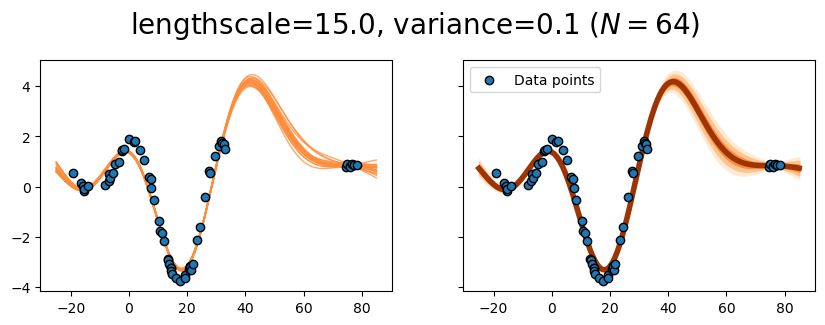

In [128]:
params_2 = {"lengthscale": 15.0, "variance": 0.1}
f_mean, f_cov = predict_f_posterior(params_2, rbf_kernel, X, y, Xt)
np.random.seed(0)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(X, y, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"lengthscale={params_2['lengthscale']}, variance={params_2['variance']} ($N={len(X)}$)", y=1.05, fontsize=20)


plt.show()

# 3. Model evaluation

**Exercise:**
As a measure of model quality, you should also compute the (log) marginal likelihood of the model.
For this, complete the function below to compute the log marginal likelihood (disregard the decorator above).

In [129]:
@functools.partial(jax.jit, static_argnums=(1))
def marginal_likelihood(params, kernel_fn, X, y, sn2=0.01):
     K = kernel_fn(params, X, X) + sn2 * jnp.eye(len(X))
     L = jnp.linalg.cholesky(K)
     V = jnp.linalg.solve(L, y)
     ll = len(X) * (np.log(2 * np.pi)) + jnp.log(jnp.diag(L)).sum() + (V**2).sum() 
     return -0.5 * ll

**Exercise**: Compute the marginal likelihood

In [130]:
 # @@ COMPLETE @@ #
print(marginal_likelihood(params, rbf_kernel, X, y))

-194.40176


**Exercise:**
Run a grid search over a range of parameter values in order to determine which configuration yields the best result (based on the marginal). For this exercise, use the entire dataset.

In [131]:
lengthscales = np.linspace(1, 20, 51)
variances = np.linspace(1, 20, 50)
marginal_ll = np.empty((len(lengthscales), len(variances)))
for i, lengthscale in enumerate(lengthscales):
    for j, variance in enumerate(variances):
        _params = {"lengthscale": lengthscale, "variance": variance}
        marginal_ll[i, j] =  marginal_likelihood(_params, rbf_kernel, X, y)

best = np.unravel_index(marginal_ll.argmax(), marginal_ll.shape)

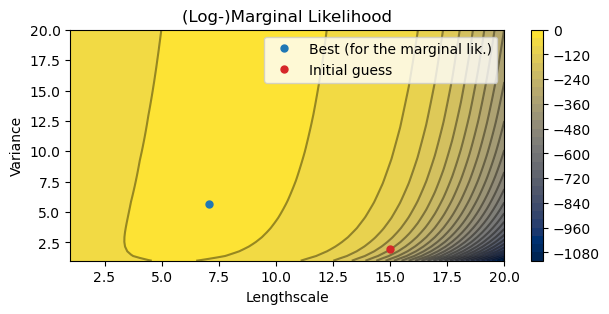

In [132]:
fig, ax = plt.subplots(figsize=(7, 3))
cset = ax.contourf(lengthscales, variances, marginal_ll.T, cmap="cividis", levels=30)
fig.colorbar(cset)
cset = ax.contour(
    lengthscales,
    variances,
    marginal_ll.T,
    colors="k",
    linestyles="-",
    alpha=0.4,
    levels=30,
)
ax.set_ylabel("Variance")
ax.set_xlabel("Lengthscale")

ax.plot(
    lengthscales[best[0]],
    variances[best[1]],
    "o",
    color="tab:blue",
    ms=5,
    label="Best (for the marginal lik.)",
)
ax.plot(
    params["lengthscale"],
    params["variance"],
    "o",
    color="tab:red",
    ms=5,
    label="Initial guess",
)
ax.set_title("(Log-)Marginal Likelihood")
ax.legend()
plt.show()

## (+) Alternative Kernel Functions
So far we have focused exclusively on the RBF kernel.
However, the choice of kernel function (along with its associated parameters) can have a significant effect on the overall Gaussian process model.
Choosing the best kernel to fit your data is no simple task, and is a pertinent problem in many applied domains.<br>

A brief discussion on this problem may be found here: <a target="_blank" href="https://www.cs.toronto.edu/~duvenaud/cookbook/">Kernel Cookbook</a>. 

Familiarise yourself better with these issues by implementing one or two additional kernels. 

For example, another popular kernel used in GP literature is the **Matérn kernel**.
The Matérn covariance between two points separated by $d=||\mathbf{x}-\mathbf{z}||_2^2$ distance units is given by [Rasmussen & Williams](http://www.gaussianprocess.org/gpml/chapters/RW4.pdf) (Ch. 4).

$$
C_\nu(d) = \sigma^2\frac{2^{1-\nu}}{\Gamma(\nu)}\Bigg(\sqrt{2\nu}\frac{d}{\rho}\Bigg)^\nu K_\nu\Bigg(\sqrt{2\nu}\frac{d}{\rho}\Bigg),
$$

where $\Gamma$ is the Gamma function, $K_\nu$ is the modified Bessel function of the second kind, and $\rho$ and $\nu$ are non-negative parameters of the covariance.

In practice:

- for $\nu = 1/2$:    $\qquad C_{1/2}(d) = \sigma^2\exp\left(-\frac{d}{\rho}\right)$,

- for $\nu = 3/2$:    $\qquad C_{3/2}(d) = \sigma^2\left(1+\frac{\sqrt{3}d}{\rho}\right)\exp\left(-\frac{\sqrt{3}d}{\rho}\right)$,

- for $\nu = 5/2$:    $\qquad C_{5/2}(d) = \sigma^2\left(1+\frac{\sqrt{5}d}{\rho}+\frac{5d^2}{3\rho^2}\right)\exp\left(-\frac{\sqrt{5}d}{\rho}\right)$.

**Exercise:**
Pick one/two versions of the Matérn kernel and implement them. Plot the prior from the GP with this new kernel. Run the inference task and report/plot the results. *Hint:* You can reuse the code for the RBF kernel to compute the distances and you don't need to change the inference function.


In [133]:
def matern_kernel_12(params, X1, X2):
    lengthscale = params["lengthscale"]
    variance = params["variance"]
    D = cdist(X1, X2)
    return variance * jnp.exp(- D / lengthscale)

def matern_kernel_32(params, X1, X2):
    lengthscale = params["lengthscale"]
    variance = params["variance"]
    D = cdist(X1, X2)
    return variance * (1 + jnp.sqrt(3) * D / lengthscale) * jnp.exp(-jnp.sqrt(3) * D / lengthscale)

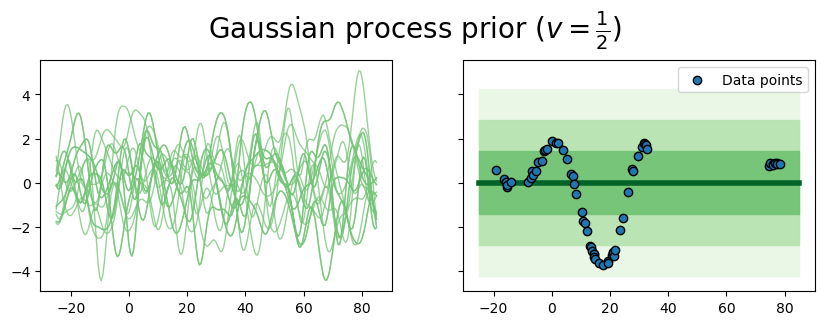

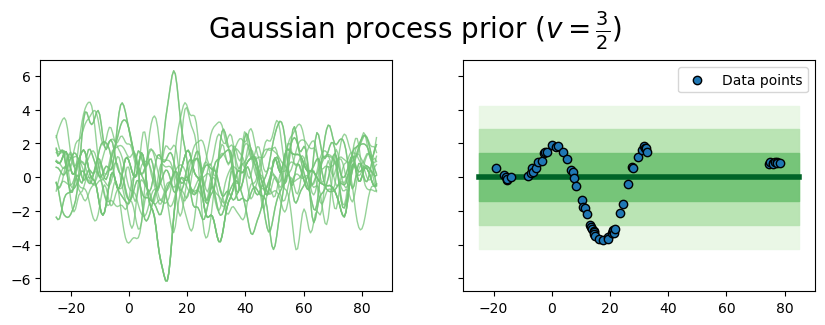

In [134]:
# plot on the same figure the two priors with the two different kernels
params = {"lengthscale": 15.0, "variance": 2.0}

samples, mean, cov = sample_f_prior(params, matern_kernel_12, Xt)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(r"Gaussian process prior ($v=\frac{1}{2}$)", y=1.05, fontsize=20)
plt.show()

params = {"lengthscale": 15.0, "variance": 2.0}

samples, mean, cov = sample_f_prior(params, matern_kernel_32, Xt)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)
plot_samples(Xt, samples, ax=ax0)
plot_gp(Xt, mean, cov, ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(r"Gaussian process prior ($v=\frac{3}{2}$)", y=1.05, fontsize=20)

plt.show()

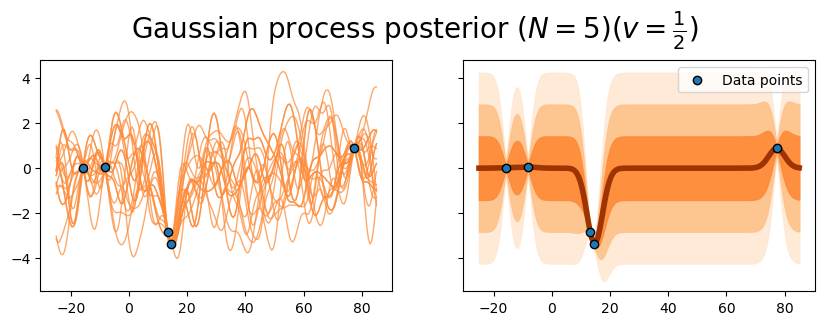

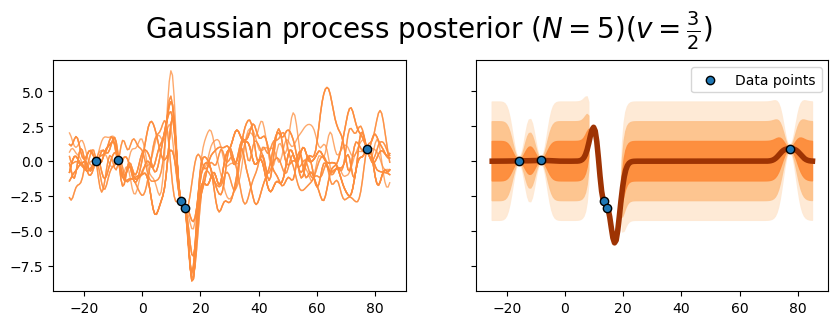

In [135]:
np.random.seed(0)
f_mean, f_cov = predict_f_posterior(params, matern_kernel_12, Xtr, ytr, Xt)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(Xtr, ytr, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(Xtr, ytr, ax1)
ax1.legend()
fig.suptitle(f"Gaussian process posterior ($N={len(Xtr)}$)"+ r"($v=\frac{1}{2}$)", y=1.05, fontsize=20)

plt.show()

f_mean, f_cov = predict_f_posterior(params, matern_kernel_32, Xtr, ytr, Xt)
samples = np.random.multivariate_normal(f_mean, f_cov, 10)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[10, 3], sharey=True)

plot_samples(Xt, samples, palette="Oranges", ax=ax0)
plot_data(Xtr, ytr, ax0)
plot_gp(Xt, f_mean, f_cov, ax=ax1, palette="Oranges")
plot_data(Xtr, ytr, ax1)
ax1.legend()
fig.suptitle(f"Gaussian process posterior ($N={len(Xtr)}$)" + r"($v=\frac{3}{2}$)", y=1.05, fontsize=20)

plt.show()



# 4. Parameter Optimisation using Gradients

Optimise the hyperparameters of the model by maximizing the marginal likelihood of the model. 
To do so, you compute the gradients of the objective function with respect to the parameters being optimised.
The general formula is given below:

$$
\nabla_{\boldsymbol\theta}\mathcal{L}(\boldsymbol\theta) = - \frac{1}{2} \text{Tr} \left(\boldsymbol K^{-1} (\nabla_{\boldsymbol\theta}\kappa)(\boldsymbol X, \boldsymbol X) \right) + \frac{1}{2} \boldsymbol{y}^{T}\boldsymbol K^{-1} (\nabla_{\boldsymbol\theta}\kappa)(\boldsymbol X, \boldsymbol X) \boldsymbol K^{-1} \boldsymbol{y}.
$$

To give a more concrete example, the $(\nabla_{\boldsymbol\theta}\kappa)(\boldsymbol X, \boldsymbol X)$ term for the lengthscale parameter in the RBF kernel is computed as follows:

$$
\frac{\partial \kappa}{\partial l}(\boldsymbol x, \boldsymbol x')  = \sigma_{f}^2 \exp \left( -\dfrac {(\boldsymbol{x}-\boldsymbol{x}')^2}{2l^2} \right)\left( \dfrac {(\boldsymbol{x}-\boldsymbol{x}')^2}{l^3} \right)
$$

Then, you can use the classic gradient **ascent** algorithm,

$$
\boldsymbol\theta_{t+1} = \boldsymbol\theta_{t} + \eta (\nabla_{\boldsymbol\theta}\mathcal{L})(\boldsymbol\theta_{t}) 
$$

## The "Millenial" version (with the automatic differentiation of Jax)

We don't really need to derive the gradients of the marginal likelihood w.r.t. parameters by hand. We can leverage the automatic differentiation engine in JAX! If you followed the instruction at the beginning of the notebook, all the operations we used are all differentiable. Let's take advantage of that! 

JAX has a pretty general automatic differentiation system.
Generally, you can differentiate a (scalar) function with `jax.grad`. which operates on functions and returns a function. 
If you have a Python function `f` that evaluates the mathematical function $f$, then `jax.grad(f)` is a Python function that evaluates the mathematical function $\nabla f$. 
That means `jax.grad(f)(x_i)` represents the value $\nabla f(x_i)$.

Another convenient function is `jax.value_and_grad` for efficiently computing both a function's value as well as its gradient's value:

Generally gradients are computed w.r.t. the first argument of the function, however differentiating with respect to standard Python containers just works, so use tuples, lists, and dicts (and arbitrary nesting) however you like.
This is why in the beginning we put all the kernel parameters in a dictionary. 

This `grad` API has a direct correspondence to the excellent notation in Spivak's classic *Calculus on Manifolds* (1965), also used in Sussman and Wisdom's [*Structure and Interpretation of Classical Mechanics*](http://mitpress.mit.edu/sites/default/files/titles/content/sicm_edition_2/book.html) (2015) and their [*Functional Differential Geometry*](https://mitpress.mit.edu/books/functional-differential-geometry) (2013). Both books are open-access.


Let's now implement this for our case. 
First of all, the next function implements the gradient update for the gradient ascent algorithm.

In [136]:
def gradient_update(params, gradients, learning_rate):
    updated_params = jax.tree_map(lambda p, g: p + learning_rate * g, params, gradients)
    return updated_params

**Exercise**: Compute the gradient function of the marginal likelihood, using `jax.grad` 

In [137]:
grad_marginal_likelihood = jax.grad(marginal_likelihood)
# @@ COMPLETE @@ #

**Exercise**: Complete the training loop, and also keep track of the marginal during optimization

In [138]:
params = {"lengthscale": 1.0, "variance": 1.0}  # Initial guess
marginals = []  # Keep track of the marginal for plotting here
for _ in range(2000):
    value = marginal_likelihood(params, rbf_kernel, X, y)
    gradients = grad_marginal_likelihood(params, rbf_kernel, X, y)
    params = gradient_update(params, gradients, 0.001)
    marginals.append(value)
    # @@ COMPLETE @@ #
params

{'lengthscale': Array(6.1108837, dtype=float32, weak_type=True),
 'variance': Array(2.910909, dtype=float32, weak_type=True)}

**Exercise:**
Plot the marginal likelihood during optimization

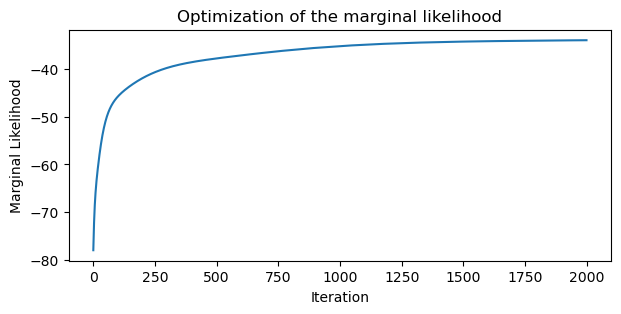

In [139]:
fig, ax = plt.subplots(figsize=[7, 3])
ax.plot(marginals, label="Marginal likelihood")
# @@ COMPLETE @@ #

ax.set_title("Optimization of the marginal likelihood")
ax.set_xlabel("Iteration")
ax.set_ylabel("Marginal Likelihood")
plt.show()

**Exercise:**
Finally, with these parameters, plot the predictive posterior as we did before.

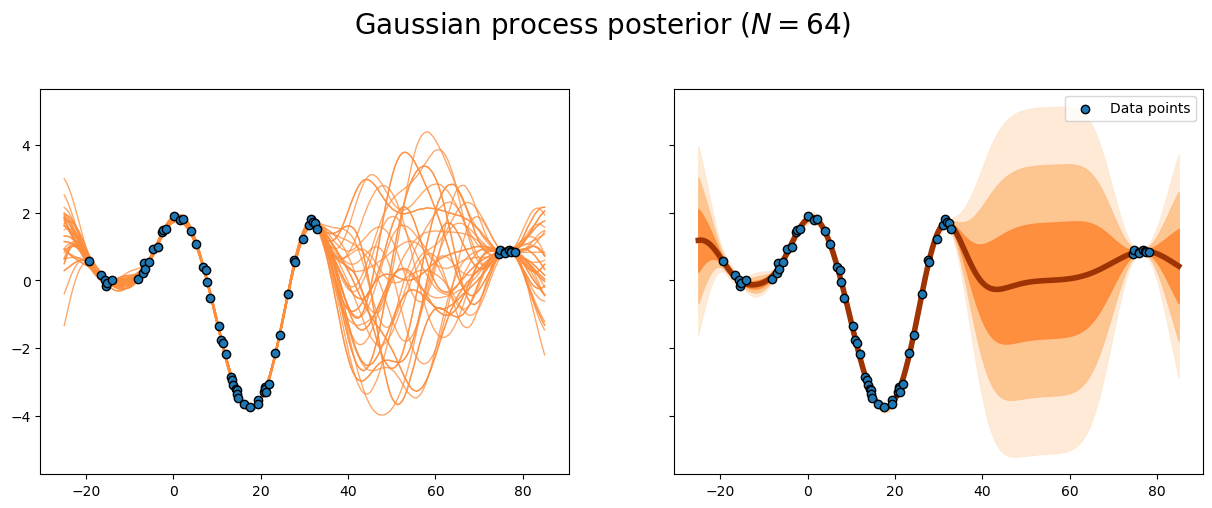

In [140]:
np.random.seed(0)
f_mean, f_cov = predict_f_posterior(params, rbf_kernel, X, y, Xt, sn2=0.01)
samples = np.random.multivariate_normal(f_mean, f_cov, 50)

fig, (ax0, ax1) = plt.subplots(1, 2, figsize=[15, 5], sharey=True)
plot_samples(Xt, samples, palette="Oranges", ax=ax0, N=40)
plot_data(X, y, ax0)
plot_gp(Xt, f_mean, f_cov, palette="Oranges", ax=ax1)
plot_data(X, y, ax1)
ax1.legend()
fig.suptitle(f"Gaussian process posterior ($N={len(X)}$)", y=1.04, fontsize=20)
plt.show()

# @@ COMPLETE @@ #

**Pro tip:** Note that the RBF kernel parameters $l$ and $\sigma_\mathrm{f}^2$ are always expected to be positive. It is possible that the optimisation algorithm attempts to evaluate the marginal likelihood in regions of the parameter space where one or more of these parameters are negative, leading to numerical issues. 
A commonly-used technique to enforce this condition is to work with a transformed version of covariance parameters using the logarithm transformation. In particular, define $\psi_l = \log(l)$ and $\psi_{f} = \log(\sigma_{f}^2 )$ and optimise with respect to the $\Psi$ parameters. 
The optimisation problem in the transformed space is now unbounded, and the gradient of the likelihood should be computed with respect to the $\Psi$ parameters.